#Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Cx_Feedback_Analysis_System/emotion
!ls

/content/drive/My Drive/Cx_Feedback_Analysis_System/emotion
dataset  model


# Import Libraries/ Functions

In [ ]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

#Import Dataset

In [ ]:
dataset_folder='./dataset/CK+48'
sub_folders=os.listdir(dataset_folder)

sub_folders

['.DS_Store',
 'disgust',
 'fear',
 'contempt',
 'anger',
 'sadness',
 'surprise',
 'happy']

In [ ]:
# Reading folder names as labels and images underneath
i=0
last=[]
images=[]
labels=[]
temp = sub_folders

# reading folders in the main dataset folder, one at a time
for sub_folder in sub_folders:
  # Check if the item is a directory before proceeding
  if os.path.isdir(os.path.join(dataset_folder, sub_folder)):
    sub_folder_index = temp.index(sub_folder)
    label = sub_folder_index

    # Define labels basis use case. using positive:0, negative:1, neutral:2
    # for the use case of predicting the emotions of customers
    if  label in [4, 6]:    # label in ['happy', 'surprise']
      new_label=0           # changed to label = positive emotion
    elif label in [0,5]:      # label in ['anger','sadness']
      new_label=1             # changed to label = negative emotion
    else:                       # label in ['contempt', 'disgust', 'fear']
      new_label=2               # changed to label = neutral emotion


    path = dataset_folder+'/'+sub_folder
    sub_folder_images= os.listdir(path)

    # reading images in the sub folder, one at a time
    for image in sub_folder_images:
      image_path = path+'/'+image
      print(image_path+"\t"+str(new_label))

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image= cv2.resize(image,(48,48))
      images.append(image)
      labels.append(new_label)
      i+=1
    last.append(i)

./dataset/CK+48/disgust/S005_001_00000009.png	2
./dataset/CK+48/disgust/S005_001_00000011.png	2
./dataset/CK+48/disgust/S011_005_00000019.png	2
./dataset/CK+48/disgust/S005_001_00000010.png	2
./dataset/CK+48/disgust/S011_005_00000020.png	2
./dataset/CK+48/disgust/S011_005_00000018.png	2
./dataset/CK+48/disgust/S032_005_00000015.png	2
./dataset/CK+48/disgust/S032_005_00000014.png	2
./dataset/CK+48/disgust/S022_006_00000017.png	2
./dataset/CK+48/disgust/S022_006_00000015.png	2
./dataset/CK+48/disgust/S022_006_00000016.png	2
./dataset/CK+48/disgust/S035_005_00000018.png	2
./dataset/CK+48/disgust/S044_006_00000017.png	2
./dataset/CK+48/disgust/S035_005_00000017.png	2
./dataset/CK+48/disgust/S035_005_00000019.png	2
./dataset/CK+48/disgust/S032_005_00000016.png	2
./dataset/CK+48/disgust/S044_006_00000019.png	2
./dataset/CK+48/disgust/S045_004_00000013.png	2
./dataset/CK+48/disgust/S044_006_00000018.png	2
./dataset/CK+48/disgust/S046_004_00000015.png	2
./dataset/CK+48/disgust/S045_004_0000001

In [ ]:
images_x = np.array(images)
labels_y = np.array(labels)

# divide image pixels by 255 to reduce computation power
images_x = images_x/255

In [ ]:
images_x.shape

(981, 48, 48)

In [ ]:
# encoding the labels
num_of_classes = 3
labels_y_encoded = tf.keras.utils.to_categorical(labels_y,num_classes=num_of_classes)


# Split Train / Test

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

In [ ]:
len(X_train)

735

In [ ]:
len(X_test)

246

# Define CNN Architecture

In [ ]:
input = Input(shape = (48,48,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(3,activation="softmax")(drop_1)  #softmax sigmoid

In [ ]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 683,267 (2.61 MB)

 Trainable params: 683,267 (2.61 MB)

 Non-trainable params: 0 (0.00 B)



# Model Training


In [ ]:
fle_s='./model/emotion_model.keras' # Change the file extension to .keras
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [ ]:
save = model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4785 - loss: 1.2225
Epoch 1: loss improved from inf to 1.16301, saving model to ./model/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.4789 - loss: 1.2200 - val_accuracy: 0.5407 - val_loss: 1.1187
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5136 - loss: 1.0672
Epoch 2: loss improved from 1.16301 to 1.05368, saving model to ./model/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.5142 - loss: 1.0666 - val_accuracy: 0.6301 - val_loss: 1.0036
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5874 - loss: 1.0024
Epoch 3: loss improved from 1.05368 to 0.90432, saving model to ./model/emotion_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.5901 - loss: 0.9984 - val_accuracy: 0.7642 - val_loss: 0.7297
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7421 - loss: 0.7313
Epoch 4: loss improved from 0.90

# Model Performance

Import necessary libraries:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Make predictions on the test set:

In [ ]:
# Assuming 'model' is your trained Keras model and 'X_test' is your test data
predictions = model.predict(X_test)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
# Get true labels from Y_test
true_labels = np.argmax(Y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


Calculate the metrics:

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9878048780487805
Precision: 0.988198269079465
Recall: 0.9878048780487805
F1-score: 0.9874794268339175


loss and accuracy

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

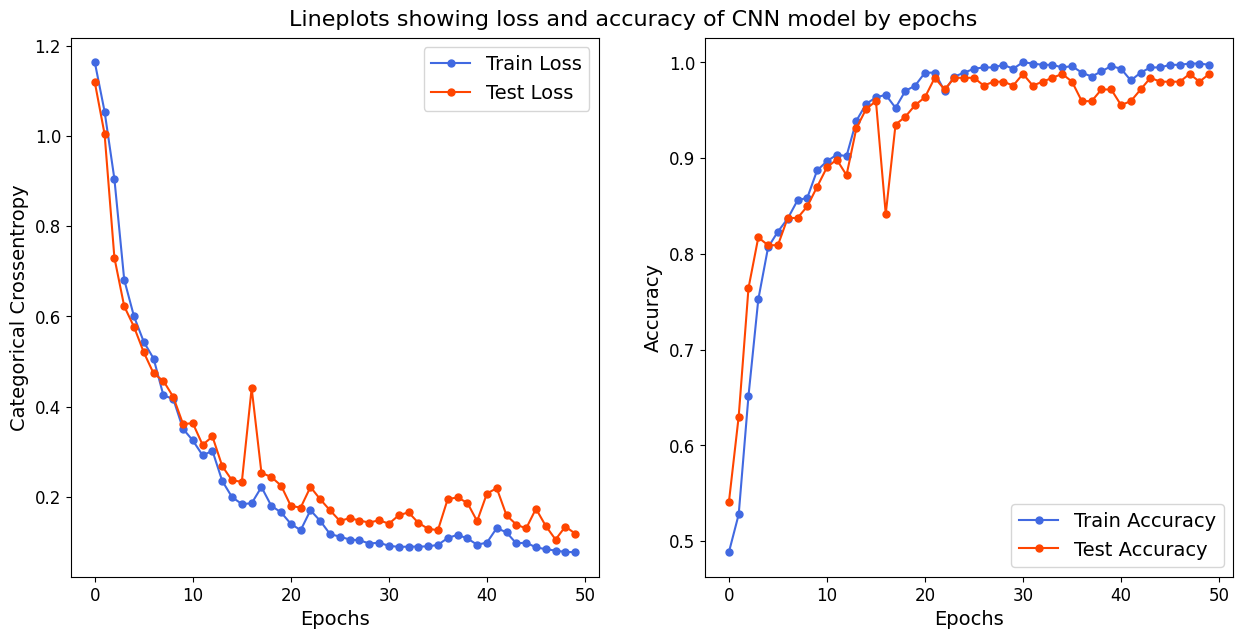

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

#confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative', 'neutral'])

In [ ]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual Positive', 'Actual Negative', 'Actual Neutral'], columns=['Predicted Positive', 'Predicted Negative', 'Predicted Neutral'])

# Display the DataFrame
display(cm_df)

,Predicted Positive,Predicted Negative,Predicted Neutral
Actual Positive,90,0,0
Actual Negative,3,20,0
Actual Neutral,0,0,133


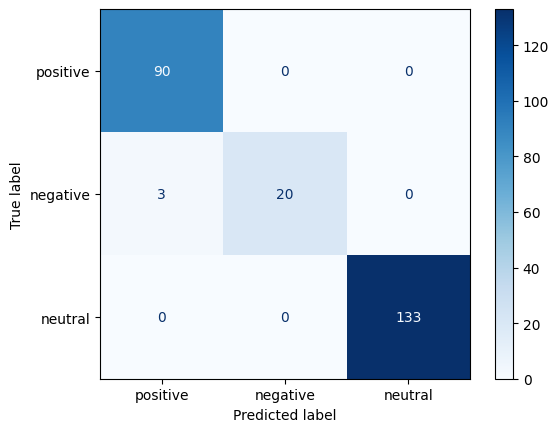

In [ ]:
disp.plot(cmap=plt.cm.Blues)
plt.show()